# Imorts

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
from functools import partial
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

# Prepare the files

If you run this notebook locally, change to the absolute path, where the dataset is donwloaded (ends with `lung-and-colon-cancer-histopathological-image`):

In [3]:
INPUT_ROOT = '/kaggle/input/lung-and-colon-cancer-histopathological-images'
DATA_DIR = os.path.join(INPUT_ROOT, 'lung_colon_image_set', 'lung_image_sets')

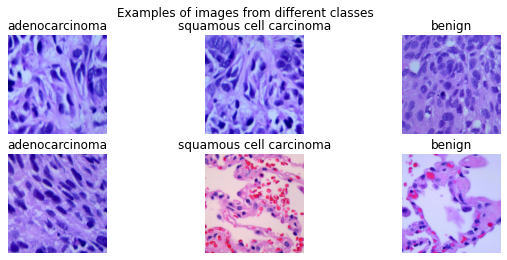

In [4]:
examples = (
    ('lung_aca', 'lungaca1914.jpeg'),
    ('lung_aca', 'lungaca1915.jpeg'),
    ('lung_scc', 'lungscc1930.jpeg'),
    ('lung_scc', 'lungscc1931.jpeg'),
    ('lung_n', 'lungn691.jpeg'),
    ('lung_n', 'lungn692.jpeg')
)

filenames = tuple(os.path.join(DATA_DIR, *path) for path in examples)
titles = ('adenocarcinoma', 'squamous cell carcinoma', 'benign') * 2

fig, axs = plt.subplots(2, 3)
fig.set_figwidth(10)
fig.suptitle('Examples of images from different classes')

for imgname, title, ax in zip(filenames, titles, axs.flatten()):
    ax.imshow(image.load_img(imgname))
    ax.axis('off')
    ax.set_title(title)
plt.show()

These [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3914971/) and [article](https://www.hopkinsmedicine.org/health/conditions-and-diseases/lung-cancer/lung-cancer-types) help to understand what these types mean for medicine.

# Generate the data

In [5]:
data = image.ImageDataGenerator(validation_split = 0.2)
BATCH_SIZE = 15
# Change batch size, if you run out of memory!
# Or increase it, if you have a lot of RAM (>> 16 Gb) for faster trainig
IMG_SHAPE = (224, 224, 3)

In [6]:
generate_data = partial(
    data.flow_from_directory,
    DATA_DIR,
    class_mode = 'categorical',
    color_mode = 'rgb',
    target_size = IMG_SHAPE[:2],
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 666
)

print('Trainig data:')
train_iter = generate_data(subset='training')
print('Validating data:')
validate_iter = generate_data(subset='validation')

Trainig data:
Found 12000 images belonging to 3 classes.
Validating data:
Found 3000 images belonging to 3 classes.


# Fine-tuned models

Some constants that are used for this particular dataset:

In [7]:
CLASSES_NUM = 3
ACCURACY_THRESHOLD = 0.99

# Set to True to train simple from scratch CNN
RUN_SIMPLE_CNN = False

# Set to True to use fine-tuning
RUN_PRETRAINED = True

### Preparing pretrained models

In [8]:
PreparedModel = namedtuple('PreparedModel', ['name', 'keras_pretrained', 'optimizer'])

In [9]:
def get_keras_pretrained(keras_model):
    pretrained = keras_model(
        input_shape=IMG_SHAPE,
        weights='imagenet',
        include_top=False
    )
    pretrained.trainable = False
    return pretrained

In [10]:
if RUN_PRETRAINED:
    prepared_VGG16 = PreparedModel('VGG16', get_keras_pretrained(VGG16), 'adam')

    prepared_EfficientNetB7 = PreparedModel('EfficientNetB7', get_keras_pretrained(EfficientNetB7), 'adam')

    prepared_InceptionV3 = PreparedModel('InceptionV3', get_keras_pretrained(InceptionV3), SGD(learning_rate=0.001, momentum=0.9))

    prepared_ResNet50 = PreparedModel('ResNet50', get_keras_pretrained(ResNet50), 'adam')

    # If you have no time limit, you can include all the models and run it
    # But if you use kaggle, it's better to include just one and run multiple times
    # You can also use the callback below or EarlyStopping
    # models = [prepared_VGG16, prepared_EfficientNetB7, prepared_InceptionV3, prepared_ResNet50]
    models = [prepared_ResNet50]

2022-05-29 17:19:44.989530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 17:19:45.119986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 17:19:45.120833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 17:19:45.122052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
class TresholdStopping(tf.keras.callbacks.Callback):
    
    def __init__(self, point):
        super(TresholdStopping, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs['val_accuracy']
        if accuracy >= self.point:
            self.model.stop_training = True

treshold_stopping = TresholdStopping(ACCURACY_THRESHOLD)

### Fit using our top layer

In [12]:
def top_layer(output):
    layer = GlobalAveragePooling2D()(output)
    layer = Flatten()(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dense(CLASSES_NUM, activation='softmax')(layer)
    return layer

Fit the models, saving weigths and logs

In [13]:
if RUN_PRETRAINED:    
    for prepared_model in models:

        keras_pretrained = prepared_model.keras_pretrained

        model = Model(inputs=keras_pretrained.input, outputs=top_layer(keras_pretrained.output))

        model.compile(
          loss='categorical_crossentropy',
          optimizer=prepared_model.optimizer,
          metrics=['accuracy'],

        )

        checkpointing = ModelCheckpoint(
            filepath=prepared_model.name,
            save_weights_only=True,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )

        log_saving = CSVLogger(f'{prepared_model.name}-log.csv', append=True, separator=';')

        print(f'STARTED TRAINIG OF {prepared_model.name} PREPARED MODEL')

        model.fit(
            train_iter,
            validation_data=validate_iter,
            epochs=50,
            callbacks=[checkpointing, log_saving]
        )

        print(f'TRAINIG OF {prepared_model.name} COMPLETED')
        print('------------------------------')

STARTED TRAINIG OF ResNet50 PREPARED MODEL


2022-05-29 17:19:59.575698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-29 17:20:03.535929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


800/800 [==============================] - 207s 247ms/step - loss: 0.2533 - accuracy: 0.9072 - val_loss: 0.0925 - val_accuracy: 0.9620

Epoch 00001: val_accuracy improved from -inf to 0.96200, saving model to ResNet50
Epoch 2/50
800/800 [==============================] - 140s 175ms/step - loss: 0.1149 - accuracy: 0.9553 - val_loss: 0.0768 - val_accuracy: 0.9690

Epoch 00002: val_accuracy improved from 0.96200 to 0.96900, saving model to ResNet50
Epoch 3/50
800/800 [==============================] - 138s 172ms/step - loss: 0.0987 - accuracy: 0.9589 - val_loss: 0.0617 - val_accuracy: 0.9737

Epoch 00003: val_accuracy improved from 0.96900 to 0.97367, saving model to ResNet50
Epoch 4/50
800/800 [==============================] - 138s 172ms/step - loss: 0.0820 - accuracy: 0.9681 - val_loss: 0.0663 - val_accuracy: 0.9770

Epoch 00004: val_accuracy improved from 0.97367 to 0.97700, saving model to ResNet50
Epoch 5/50
800/800 [==============================] - 138s 172ms/step - loss: 0.0843 -

# Model from scratch

To compare with fine-tuning approach, we will also train simple CNN model without any typical architecture and weights.

In [14]:
# Features extraction layers
simple_CNN_model = tf.keras.models.Sequential([
    
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(2),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2),
  
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(2)
])

# Classification layers
simple_CNN_model.add(Flatten())
simple_CNN_model.add(Dense(128, activation='relu'))
simple_CNN_model.add(Dense(64, activation='relu'))
simple_CNN_model.add(Dense(CLASSES_NUM, activation='softmax'))

In [15]:
simple_CNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])

Callbacks for saving weigths and log:

In [16]:
name = 'SimpleCNN'

checkpointing = ModelCheckpoint(
    filepath=name,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_acc',
    verbose=1
)

log_saving = CSVLogger(f'{name}-log.csv', append=True, separator=';')

In [17]:
if RUN_SIMPLE_CNN:
    
    print(f'{name} IS READY FOR TRAINIG:')
    simple_CNN_model.summary()
    
    print(f'STARTED TRAINIG OF {name} FROM SCRATCH MODEL')

    simple_CNN_model.fit(
        train_iter,
        validation_data=validate_iter,
        epochs=50,
        callbacks=[checkpointing, log_saving]
    )

    print(f'TRAINIG OF {name} COMPLETED')
    print('------------------------------')